Отчёт по лабораторной работе номер 7. Бабенко Р. НММбд-01-22

Задачи:

1. К алгоритму kNN, реализованному в этой работе, реализовать добавление весов для соседей по любому из показанных в этой лабораторной принципов.
2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данной лабораторной.
3. Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

Задача 1.

In [114]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

def e_metrics(x1, x2):  
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

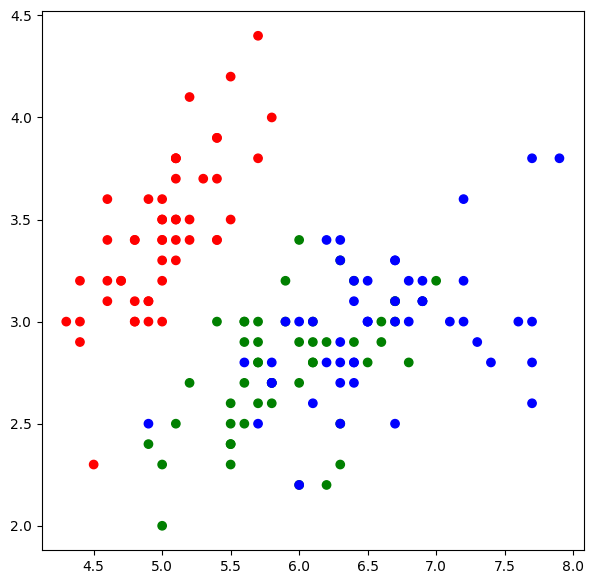

In [115]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Будем модифицировать функцию алгоритма knn

Создадим функцию get_weigth, которая будет возвращать большее значение при большом расстоянии и меньшее при маленьком.

При подсчёте будем учитывать не количество элементов класса, а сумму их весов, и по ним определять принадлежность 

За функцию расчёта веса я решил взять такую:

### - $w(d) = q^{d}$,   $q \in (0,1)$;

In [145]:
def get_weigth(dist):
    q = 0.5
    return q**dist

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # определим вес как 
            weigth = get_weigth(distance)

            # Записываем в список значение расстояния, ответа и веса на объекте обучающей выборки
            test_distances.append((distance, y_train[i], weigth))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов не будем записывать их количество, а добавлять сумму их весов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += d[2]

        # Записываем в список ответов наиболее "тяжёлый" класс по сумме элементов
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [146]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма

Выведем его точность и построим график

In [159]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.767


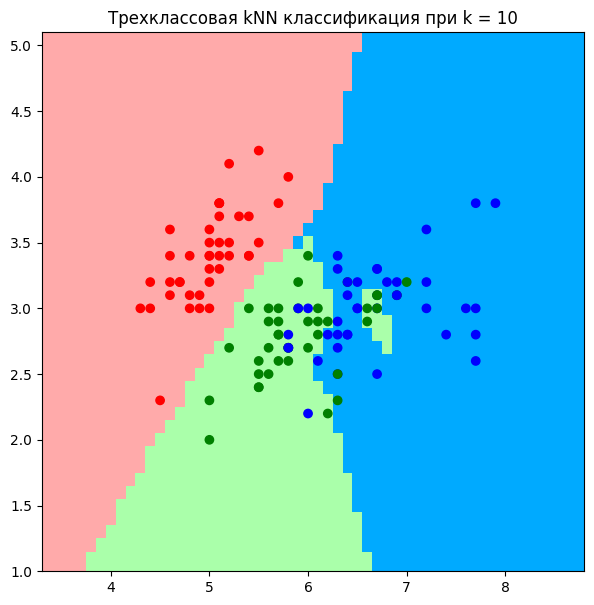

In [149]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

get_graph(X_train, y_train, k)

Как мы можем видеть, наш алгоритм работает :)

Задача 2.

Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данной лабораторной.

- среднее квадратичное внутрикластерное

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
 

In [120]:
# сразу опишу функцию, которую я реализовал

def MIID(clusters, centroids):
    K = len(clusters) # получаем количество кластеров
    distanse = 0 # сюда будем складывать расстояния до сетнроидов
    for cluster in range(len(clusters)): # перебираем каджый кластер, чтобы посчитать для них стреднее крадратичное расстояние
        current_cluster = clusters[cluster] # для удобства запишем в переменную текущий кластер
        current_centroid = centroids[cluster] # и текущий центроид
        for element in current_cluster:
            distanse += e_metrics(element, current_centroid)**2 # прибвляем расстояние до центроида, возведённое в квадрат 
    return distanse / K # возвращаем его, делённое на количество кластеров

In [121]:
# датасет
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1)

In [122]:
# скопипастим алгоритм k-means

def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters


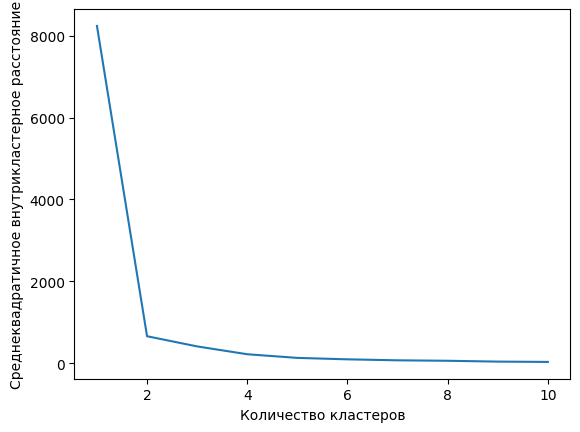

In [126]:
# максимальное количество итераций
max_iterations = 5

#  минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# создадим массив, с помошью которого будем перебирать количество кластеров
k_ = [i for i in range(1, 11)]

mean_q_distanse = []
for k in k_:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    mean_q_distanse.append(MIID(clusters, centroids))

plt.figure()
plt.plot(k_, mean_q_distanse)
plt.xlabel('Количество кластеров')
plt.ylabel('Среднеквадратичное внутрикластерное расстояние')
plt.show()


Вывод: при увеличении количества кластеров значение нашей метрики уменьшается, так как вариативность точек внутри кластеров уменьшается, соответственно расстояния тоже становятся меньше

Задача 3.

Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [203]:
def knn_new(x_train, y_train, x_test, k):
    def get_predict(x):
        test_distances = list(np.array(sorted([[e_metrics(x, x_train[i]), y_train[i]] for i in range(len(x_train))])[0:k])[:, 1])
        return max(set(test_distances), key=test_distances.count)
    
    answers = list(map(lambda x: get_predict(x), x_test))
    return answers

Вот так получилось отрефакторить функцию, теперь в ней нет циклов (Ну только генератор массива, по сути тот же цикл).

Вкратаце: 

get_predict - вложенная, которая вернёт класс к которому принадлежит объект. Мы мапкой (map() ) применяем эту функцию ко всем элементам тестовой выборки

Проверим корректность работы 

Точность алгоритма при k = 10: 0.733


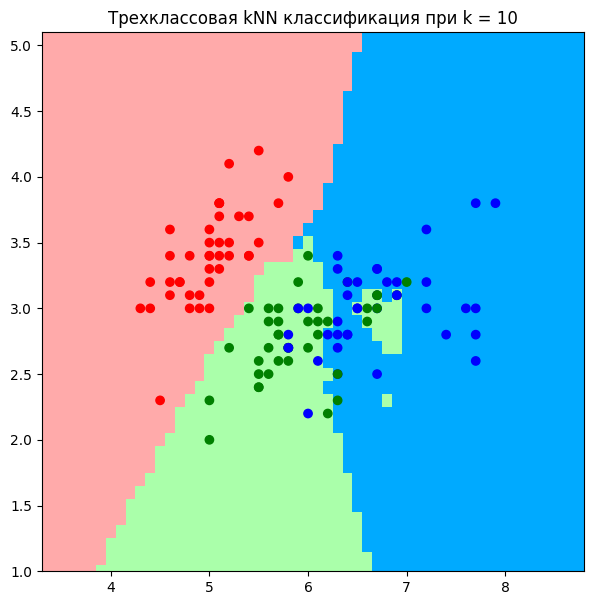

In [204]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

k = 10

def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_new(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()


y_pred = knn_new(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

get_graph(X_train, y_train, k)


Всё работает. Уря)